# 46-926, Statistical Machine Learning 1: Homework 5

*Author*  : Jordan Giebas <br>
*Due Date*: Februrary 19th, 2018 

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Question 1: *Exploring ROC curves and AUC*

Using the marketing data set from HW4 and the fit glm model, determine the predicted probabilities for each points in the test data set. From these, compute the logit transformation 

$$ log\bigg(\frac{p(x_i)}{1-p(x_i)}\bigg) $$

In [2]:
# Load necessary modules
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
%matplotlib inline

# Load the DataFrame
df = pd.read_csv("marketing.csv")

# Adjust for categorical data
df.y = np.where(df.y == 'yes', 1, 0)
df = pd.get_dummies(df)

# Split the dataset into training and test data - as specified
X = df.drop('y', axis=1)
y = df.y
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=1)

# Fit the linear model
lmfit = LogisticRegression(C=100000).fit(X_train, y_train)

# Perform the prediction
y_pred = lmfit.predict(X_test)

Percent of clients with highest probability that actually say yes: 27.900000


### Part (a) 

Make a histogram of your logit scores

In [3]:
# Fit Logistic Gam
from pygam import LogisticGAM
gam = LogisticGAM().gridsearch(X_train,y_train,lam = np.logspace(-0.5, -0.25, 30))
yhat_gam = gam.predict(X_test)

N/A% (0 of 30) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 2
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 4
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 5
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 6
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 7
  self._validate_data_dep_params(X)
/usr/local/lib/python

/usr/local/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/pygam/distributions.py:269: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return weights * (sp.misc.comb(n, y) * (mu / n)**y *
  6% (2 of 30) |#                         | Elapsed Time: 0:00:07 ETA:  0:01:45/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 2
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-pac

/usr/local/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/pygam/distributions.py:269: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return weights * (sp.misc.comb(n, y) * (mu / n)**y *
 13% (4 of 30) |###                       | Elapsed Time: 0:00:13 ETA:  0:01:28/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 2
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-pac

/usr/local/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/pygam/distributions.py:269: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return weights * (sp.misc.comb(n, y) * (mu / n)**y *
 20% (6 of 30) |#####                     | Elapsed Time: 0:00:18 ETA:  0:01:14/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 2
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-pac

/usr/local/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/pygam/distributions.py:269: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return weights * (sp.misc.comb(n, y) * (mu / n)**y *
 26% (8 of 30) |######                    | Elapsed Time: 0:00:23 ETA:  0:01:05/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 2
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-pac

/usr/local/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/pygam/distributions.py:269: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return weights * (sp.misc.comb(n, y) * (mu / n)**y *
 33% (10 of 30) |########                 | Elapsed Time: 0:00:28 ETA:  0:00:53/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 2
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-pac

/usr/local/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/pygam/distributions.py:269: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return weights * (sp.misc.comb(n, y) * (mu / n)**y *
 40% (12 of 30) |##########               | Elapsed Time: 0:00:34 ETA:  0:00:47/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 2
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-pac

/usr/local/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/pygam/distributions.py:269: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return weights * (sp.misc.comb(n, y) * (mu / n)**y *
 46% (14 of 30) |###########              | Elapsed Time: 0:00:39 ETA:  0:00:40/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 2
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-pac

/usr/local/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/pygam/distributions.py:269: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return weights * (sp.misc.comb(n, y) * (mu / n)**y *
 53% (16 of 30) |#############            | Elapsed Time: 0:00:44 ETA:  0:00:35/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 2
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-pac

/usr/local/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/pygam/distributions.py:269: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return weights * (sp.misc.comb(n, y) * (mu / n)**y *
 60% (18 of 30) |###############          | Elapsed Time: 0:00:50 ETA:  0:00:31/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 2
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-pac

/usr/local/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/pygam/distributions.py:269: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return weights * (sp.misc.comb(n, y) * (mu / n)**y *
 66% (20 of 30) |################         | Elapsed Time: 0:00:57 ETA:  0:00:28/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 2
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-pac

/usr/local/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/pygam/distributions.py:269: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return weights * (sp.misc.comb(n, y) * (mu / n)**y *
 73% (22 of 30) |##################       | Elapsed Time: 0:01:03 ETA:  0:00:23/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 2
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-pac

/usr/local/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/pygam/distributions.py:269: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return weights * (sp.misc.comb(n, y) * (mu / n)**y *
 80% (24 of 30) |####################     | Elapsed Time: 0:01:08 ETA:  0:00:18/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 2
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-pac

/usr/local/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/pygam/distributions.py:269: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return weights * (sp.misc.comb(n, y) * (mu / n)**y *
 86% (26 of 30) |#####################    | Elapsed Time: 0:01:15 ETA:  0:00:12/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 2
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-pac

/usr/local/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/pygam/distributions.py:269: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return weights * (sp.misc.comb(n, y) * (mu / n)**y *
 93% (28 of 30) |#######################  | Elapsed Time: 0:01:20 ETA:  0:00:05/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 2
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-packages/pygam/pygam.py:1187: UserWarning: detected catergorical data for feature 3
  self._validate_data_dep_params(X)
/usr/local/lib/python3.6/site-pac

/usr/local/lib/python3.6/site-packages/pygam/utils.py:69: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/usr/local/lib/python3.6/site-packages/pygam/distributions.py:269: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  return weights * (sp.misc.comb(n, y) * (mu / n)**y *
100% (30 of 30) |#########################| Elapsed Time: 0:01:26 Time: 0:01:26


In [16]:
log_pr = np.array([np.log(pr/(1-pr)) for pr in gam.predict_proba(X_test)])

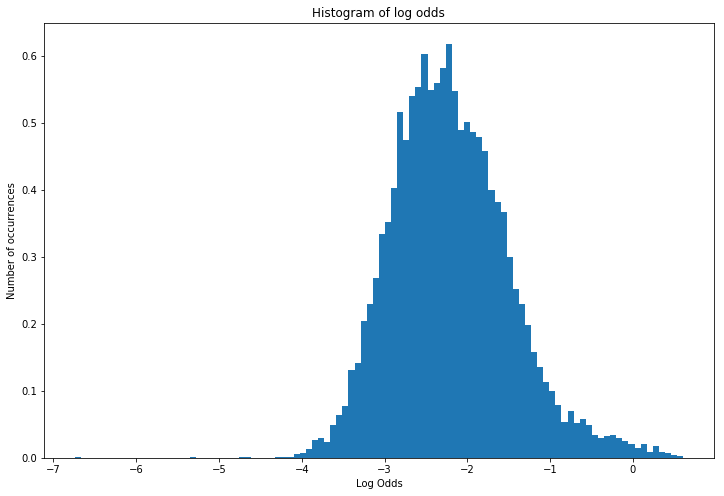

In [36]:
# Define bin count
no_bins = 50

# Plot Histogram
matplotlib.rcParams['figure.figsize'] = (12,8)
plt.xlabel("Log Odds")
plt.ylabel("Number of occurrences")
plt.title("Histogram of log odds")
_, _, _ = plt.hist(log_pr, bins=100, normed=1)

### Part (b)

Make separate histograms for the score (value classified, i.e. {0,1}?) of each class. 

In [40]:
# idea I think: Separate the observations that get classified, as 0 and 1. 
# Now do the same thing and get the log odds for each one, make histograms and stack
# them on top of one another. 

X_test.head()

,age,balance,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes
3610,42,2519,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,1,0
11677,37,2209,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
33018,32,923,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,1,0
44323,53,306,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0
8119,32,257,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,1,0


In [43]:
yhat_gam

array([False, False, False, ..., False, False, False], dtype=bool)

In [46]:
pred_df = X_test.copy()
pred_df['y_pred'] = np.where(yhat_gam == True, 1, 0)

In [50]:
true_df  = pred_df[pred_df.y_pred == 1]
false_df = pred_df[pred_df.y_pred == 0]

In [52]:
len(true_df) + len(false_df) == len(pred_df)

True

In [56]:
true_df.head()

,age,balance,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,y_pred
30641,70,5563,0,0,0,0,1,0,0,0,...,0,1,0,1,0,1,0,1,0,1
43569,76,4984,0,0,0,0,0,0,1,0,...,0,0,1,1,0,1,0,1,0,1
43129,78,3219,0,0,0,0,0,1,0,0,...,1,0,0,1,0,1,0,1,0,1
43508,74,4912,0,0,0,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,1
44139,72,402,0,0,0,0,0,1,0,0,...,0,1,0,1,0,1,0,1,0,1


In [62]:
tmp = pd.DataFrame()
tmp['log_pr'] = pd.Series(log_pr)
tmp['ypred'] = pd.Series(yhat_gam)

In [64]:
class0_logpr = tmp[tmp.ypred == False]
class1_logpr = tmp[tmp.ypred == True]

In [74]:
true_data  = class1_logpr.log_pr.tolist()
false_data = class0_logpr.log_pr.tolist()
total = [true_data,false_data]

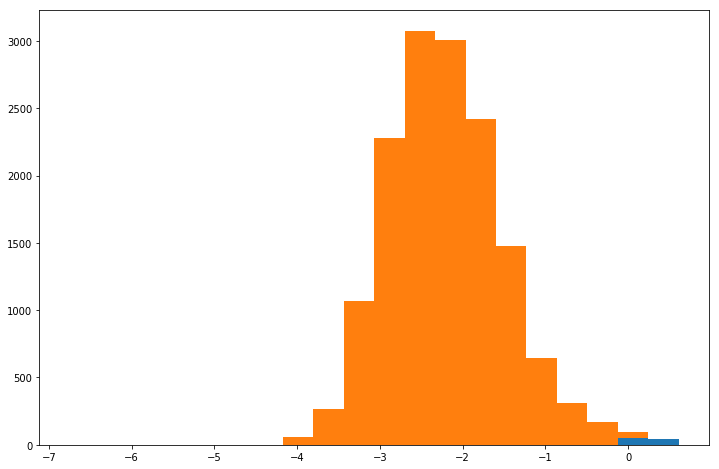

In [79]:
# Now we must plot....... fuck
fig, ax = plt.subplots(figsize=(12,8))
n,_,_ = ax.hist(total, bins=20, stacked=True)

Maybe we should plot them separately first.